# Colab setup


In [0]:
from os import path
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())

accelerator = 'cu80' if path.exists('/opt/bin/nvidia-smi') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.0-{platform}-linux_x86_64.whl torchvision
import torch
print(torch.__version__)
print(torch.cuda.is_available())

In [0]:
!pip3 install Pillow==4.0.0
!pip3 install PIL
!pip3 install image

In [0]:
import random
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets
import torchvision.models as models
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np
import pandas as pd
import os
from PIL import Image

In [0]:
!wget https://cdn.skillenza.com/files/5ee0a2e1-bf6d-4173-8244-e75fa2d7bbe2/training.5k.zip
!unzip training.5k.zip  

In [0]:
!wget https://cdn.skillenza.com/files/7da538a3-4db6-46ea-a4f8-87a21368e5f5/testing.40k.zip
!unzip testing.40k.zip

In [0]:
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'


# Hyperparameters

In [0]:
NUM_EPOCHS = 10
LR = (1e-4)
BATCH_SIZE = 4
GAMMA = 0.95
curr_lr = LR

In [0]:
tfms = transforms.Compose([transforms.Resize((256,256)),transforms.CenterCrop((224,224)),transforms.transforms.ToTensor(), transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])])

In [0]:
categories = pd.read_csv("/content/training/solution.csv")["category"]
def getitem(idx):
    img_name = os.path.join("/content/training/training/", str(idx+1) + ".png")
    image = Image.open(img_name)
    if tfms:
        image = tfms(image)
    category = categories[idx]
    sample = {'image': image, 'category': category}

    return sample

In [0]:
a = np.arange(0,5000)
np.random.shuffle(a)
train_indexes = a[:4901]
test_indexes = a[4901:5001]

# Model

In [0]:
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

In [0]:
model = models.resnet34(pretrained=True)

model = nn.Sequential(*list(model.children())[:-2],
                     nn.Conv2d(512, 6, 3, 1),
                     nn.AdaptiveAvgPool2d(1), Flatten(),
                     nn.LogSoftmax())

if torch.cuda.is_available():
    model = model.cuda()

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=LR, momentum=0.9)

In [0]:
#print(model.children)
count = 0
for param in model.parameters():
    param.requires_grad = False
    count += 1
    if count >= 8:
        break

In [0]:
def adjust_learning_rate(optimizer, lr):
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

# Training

In [0]:
losses = []
accuracies = []
validation_accuracies=[]

In [0]:
def validation_accuracy(model):
  """
  Performs inference on the Validation set and returns the reported accuracy
  """
  correct = 0
  
  with torch.no_grad():
    for idx in range(0,99):
      data = getitem(test_indexes[idx])
      image = data['image']
      exp = data['category']
      image = image.unsqueeze(0).cuda()
      target = model(image)
      ans = (torch.argmax(target).cpu().numpy()+1)
      if (ans == exp):
        correct +=1
  return (correct/99)

  

In [0]:
for epoch in range(10):
    model.train()
    total_loss = 0
    accuracy = 0
    count = 0

    adjust_learning_rate(optimizer, curr_lr)
    curr_lr *= GAMMA
    
    optimizer.zero_grad()
    for c in range(0,int(4900/BATCH_SIZE)):
        optimizer.zero_grad()
        images = torch.zeros([BATCH_SIZE,3,224,224])
        targets = []
        for p in range(0,BATCH_SIZE):
            data = getitem(train_indexes[BATCH_SIZE*c+p])
            images[p,:,:,:] = data['image']
            targets.append(np.asscalar(data["category"])-1)
        targets = torch.LongTensor(targets)
        if torch.cuda.is_available():
            images = images.cuda()
            targets = targets.cuda()
        
        outs = model(images)
        loss = criterion(outs, targets)
        loss.backward()
        optimizer.step()
                
        total_loss += loss.data
        accuracy += torch.sum(torch.argmax(outs, dim=1) == targets)
        count += 1

        if c%300 == 0:
            print("Epoch:", epoch, "Iter:", c, "average batch loss:", total_loss/(c+1))
    
    
    print("\nEpoch:", epoch, "Total loss:", total_loss)
    acc = accuracy.cpu().numpy()/(count*BATCH_SIZE)
    print("Epoch:", epoch, "Accuracy:", acc,'\n') 
    
    model.eval()
    val_acc = validation_accuracy(model)
    print('Validation accuracy:',val_acc)
    model.train()
    
    torch.save(model.state_dict(), "resnet34_epoch_"+str(epoch)+"pt")
    losses.append(total_loss)
    accuracies.append(acc)
    validation_accuracies.append(val_acc)
    #validation_losses.append(val_loss)

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:91: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Epoch: 0 Iter: 0 average batch loss: tensor(2.2639, device='cuda:0')
Epoch: 0 Iter: 300 average batch loss: tensor(1.9122, device='cuda:0')
Epoch: 0 Iter: 600 average batch loss: tensor(1.5541, device='cuda:0')
Epoch: 0 Iter: 900 average batch loss: tensor(1.2759, device='cuda:0')
Epoch: 0 Iter: 1200 average batch loss: tensor(1.0824, device='cuda:0')

Epoch: 0 Total loss: tensor(1316.1896, device='cuda:0')
Epoch: 0 Accuracy: 0.6026530612244898 

Validation accuracy: 0.9393939393939394
Epoch: 1 Iter: 0 average batch loss: tensor(0.2833, device='cuda:0')
Epoch: 1 Iter: 300 average batch loss: tensor(0.3395, device='cuda:0')
Epoch: 1 Iter: 600 average batch loss: tensor(0.2815, device='cuda:0')
Epoch: 1 Iter: 900 average batch loss: tensor(0.2203, device='cuda:0')
Epoch: 1 Iter: 1200 average batch loss: tensor(0.1881, device='cuda:0')

Epoch: 1 Total loss: tensor(228.7975, device='cuda:0')
Epoch: 1 Accuracy: 0.9422448979591836 

Validation accuracy: 0.9292929292929293
Epoch: 2 Iter: 0 av

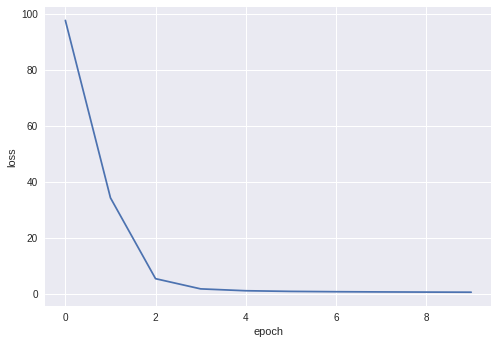

In [0]:
import matplotlib.pyplot as plt
plt.plot(losses)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

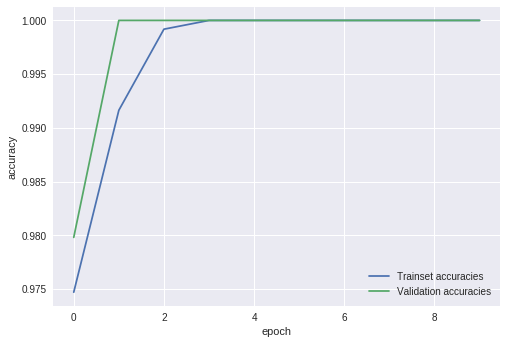

In [0]:
import matplotlib.pyplot as plt
plt.plot(accuracies,'C0',label='Trainset accuracies')
plt.plot(validation_accuracies,'C1',label='Validation accuracies')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend()
plt.show()

# Save/load model

In [0]:
torch.save(model.state_dict(), "resnet34_modekl1.pt")

In [0]:
model.load_state_dict(torch.load("resnet34_epoch_9pt"))
model.eval()

# Exporting solution to csv

In [0]:
from tqdm import tqdm

In [0]:
def answer_builder(model):
  """
  Performs inference on testset and exports predictions to answer.csv
  """
  model.eval()
  df = pd.DataFrame(columns=['id','category'])
  images =torch.empty([100,3,224,224])
  with torch.no_grad():
    for itr in tqdm(range(0,400)):
      for idx in (range(100*itr,100*(itr+1))):
        img_name = os.path.join("/content/testing/", str(idx+1) + ".png")
        image = Image.open(img_name)
        image = tfms(image)
        image = image.unsqueeze(0)
        images[idx-100*itr,:,:,:] = image
   # print('\nPerforming inference...')
      images = images.cuda()
      target = model(images)
      target = torch.argmax(target,dim=1).cpu().numpy()+1
   # print('Generating answer.csv')
      for i in range(0,100):
        df.loc[100*itr+i+1] = [100*itr+i+1, target[i]]

    df.to_csv('answer.csv', index=False)

In [0]:
answer_builder(model)

  0%|          | 0/400 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:91: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
100%|██████████| 400/400 [11:38<00:00,  1.92s/it]
